# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [1]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os
import xarray as xr

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
data_folder = 'C:/Volumes/CS185C/data'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [3]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
ssh_file_1992 = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SSHDYN','SSHDYN_1992_01.nc')

ds_1992 = xr.open_dataset(ssh_file_1992)
longitude = np.array(ds_1992['longitude'][:])
latitude = np.array(ds_1992['latitude'][:])
ssh_1992 = np.array(ds_1992['SSHDYN'][:])
ssh_1992 = ssh_1992[0, :, :]
ds_1992.close()

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ssh_file_2017 = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SSHDYN','SSHDYN_2017_01.nc')

ds_2017 = xr.open_dataset(ssh_file_2017)
ssh_2017 = np.array(ds_2017['SSHDYN'][:])
ssh_2017 = ssh_2017[0, :, :]
ds_2017.close()

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

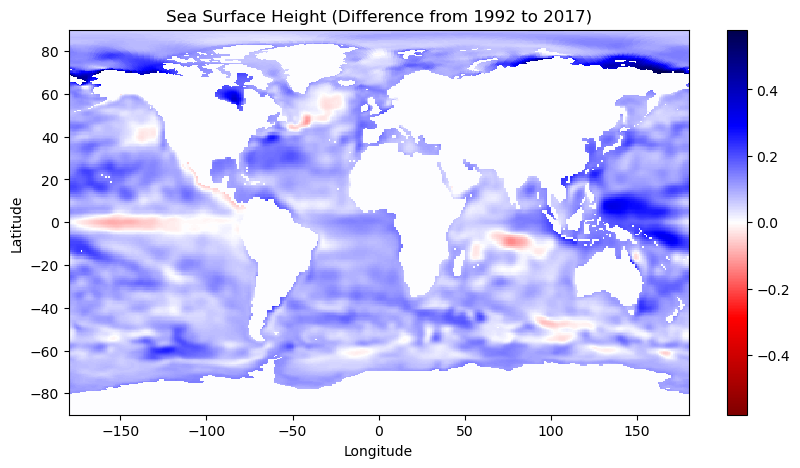

In [4]:
# make a plot of the differences between 2017 and 1992
ssh_diff = ssh_2017 - ssh_1992
# print(np.min(ssh_diff), np.max(ssh_diff)) # min: -0.136, max: 0.577
fig = plt.figure(figsize=(10,5))

# plot the temperature
plt.pcolormesh(longitude, latitude, ssh_diff, vmin=-.58, vmax=.58,
               cmap='seismic_r')
plt.colorbar(orientation = 'vertical')

# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Height (Difference from 1992 to 2017)')
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increase in sea level seems to be in the north, directly above North America and Asia. Sea level has fallen in a few places: at the equator of the Pacific Ocean, north of the Atlantic Ocean, and slightly beneath the equator of the Indian Ocean.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [5]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lat_ts = np.abs(latitude-lat).argmin()
lon_ts = np.abs(longitude-lon).argmin()

Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [6]:
ssh_files = os.listdir(os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SSHDYN'))
# ssh_files

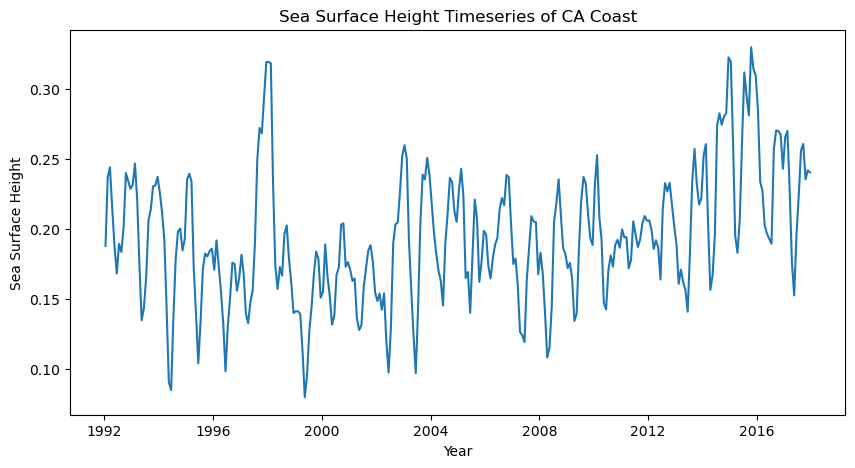

In [7]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
ssh_ts = np.zeros((len(ssh_files), 2))
ssh_path = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SSHDYN')

for i in range(len(ssh_files)):
    ssh_f = os.path.join(ssh_path, ssh_files[i])
    ds = xr.open_dataset(ssh_f)
    ssh_ts[i, 0] = ds['time'][0]
    ssh_ts[i, 1] = ds['SSHDYN'][0,lat_ts,lon_ts]
    ds.close()

fig = plt.figure(figsize=(10,5))

plt.plot(ssh_ts[:,0].astype('datetime64[ns]'), ssh_ts[:,1])

plt.xlabel('Year')
plt.ylabel('Sea Surface Height')
plt.title('Sea Surface Height Timeseries of CA Coast')
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

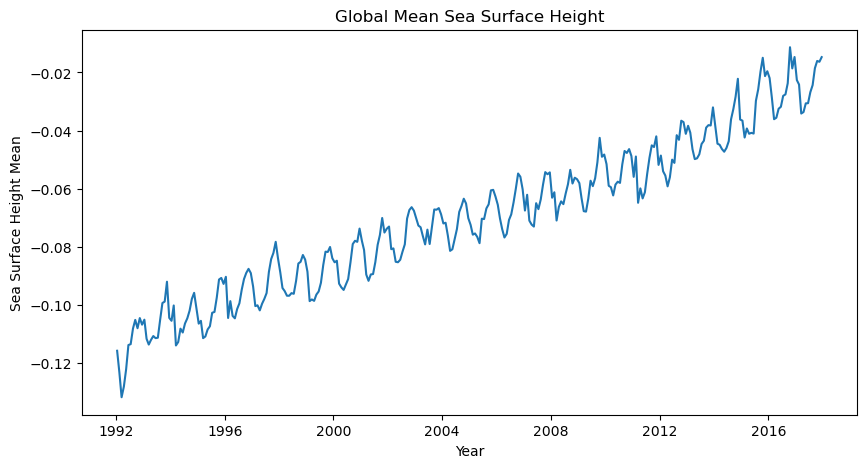

In [8]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
ssh_ts_mean = np.zeros((len(ssh_files), 2))

for i in range(len(ssh_files)):
    ssh_f = os.path.join(ssh_path, ssh_files[i])
    ds = xr.open_dataset(ssh_f)
    ssh_ts_mean[i, 0] = ds['time'][0]
    ssh_ts_mean[i, 1] = ds['SSHDYN'].where(ds['SSHDYN'] != 0).mean()
    ds.close()

fig = plt.figure(figsize=(10,5))

plt.plot(ssh_ts_mean[:,0].astype('datetime64[ns]'), ssh_ts_mean[:,1])

plt.xlabel('Year')
plt.ylabel('Sea Surface Height Mean')
plt.title('Global Mean Sea Surface Height')
plt.show()

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [9]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
months = np.arange(len(ssh_ts_mean[:,0]))
dec_yrs = 1992 + months/12

ca_ssh = np.polyfit(dec_yrs, ssh_ts[:,1],1)
gl_ssh = np.polyfit(dec_yrs, ssh_ts_mean[:,1],1)

# print out the statistics in mm/yr for each timeseries
ca_val = (ca_ssh[0]*12*1000).round(2)
gl_val = (gl_ssh[0]*12*1000).round(2)
print(f'California Sea Surface Height in mm/yr: {ca_val}')
print(f'Global Sea Surface Height in mm/yr: {gl_val}')

California Sea Surface Height in mm/yr: 24.94
Global Sea Surface Height in mm/yr: 40.52


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The trend in sea level rise in California is nearly half of the global mean rate.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

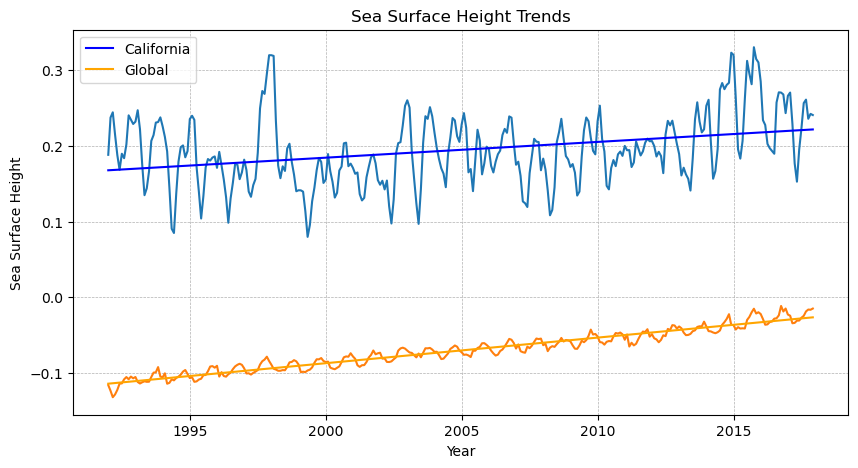

In [10]:
# create your plot here
fig = plt.figure(figsize=(10,5))

plt.plot(dec_yrs, ssh_ts[:,1])
plt.plot(dec_yrs, ssh_ts_mean[:,1])

plt.plot(dec_yrs, ca_ssh[0]*dec_yrs+ca_ssh[1], label='California', color='blue')
plt.plot(dec_yrs, gl_ssh[0]*dec_yrs+gl_ssh[1], label='Global', color='orange')

plt.xlabel('Year')
plt.ylabel('Sea Surface Height')
plt.title('Sea Surface Height Trends')
plt.legend()
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The timeseries for California is a lot more volatile and sea surface height is significantly larger than the timeseries for global mean. Both timeseries have an upward trend with roughly the same slope, with the global slope slightly higher. The two highest years of sea level in California is in around 1997-1998 and 2015-2016. These correspond with the El Nino climate pattern that happened during those times.